<a href="https://colab.research.google.com/github/vkchadha/cs634_assignment3/blob/main/cs634_assignment3_task1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.12.0


SystemError: ignored

Total # berries 162 , red berries simulated 86 , black berries simulated 76


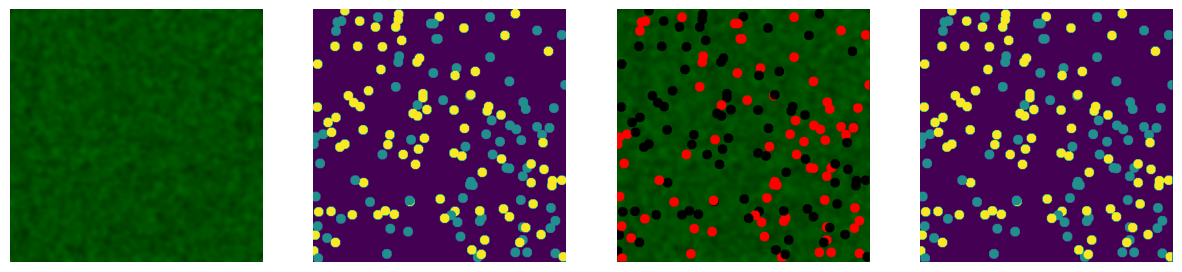

In [ ]:
import matplotlib.pylab as plt
import numpy as np
#import tensorflow as tf
import scipy.ndimage as ndimage
from skimage import draw
from collections import Counter


FULL_IMG_WIDTH = 512
FULL_IMG_HEIGHT = 512
IMG_CHANNELS = 3
PATCH_WIDTH = 32
PATCH_HEIGHT = 32
INPUT_WIDTH = PATCH_WIDTH*2
INPUT_HEIGHT = PATCH_HEIGHT*2

def generate_image(with_intermediates=False):
  # the image has a random greenish background that is smoothed
  backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
  backgr[ np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1 ] = 1
  backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

  # between 150 and 250 berries randomly placed
  num_berries = np.random.randint(150, 250)
  berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_berries)
  berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_berries)
  label = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
  label[berry_cx, berry_cy] = 1

  label = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
  red_black=[]

  #berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  berries = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])

  # draw the berries which are 10 px in radius
  # randomly assign 1 or 2 to each disk. for assigning color's the disk's.
  for idx in range(len(berry_cx)):
    rr, cc = draw.disk((berry_cx[idx], berry_cy[idx]),
                         radius=10,
                         shape=berries.shape
                         )
    color = np.random.randint(1, 3)
    red_black.append(color)
    berries[rr, cc] = color

  #assign same value to 'label[x,y]' which we had assigned to berries[x,y]
  for i in range(len(berries) - 1):
    for j in range(len(berries) - 1):
      if berries[i, j] == 1: #red
        label [i,j] = 1
      elif berries[i, j] == 2: #black
        label [i,j] = 2

  # for each disk assign red
  # Assign red color if x & y coordinates of immage are 1
  # Assign black color if x & y coordinates of immage are 2
  img = np.copy(backgr)
  for i in range(len(berries) - 1):
    for j in range(len(berries) - 1):
      if berries[i, j] == 1: #red
        img[i, j, int(0)] = 1
        img[i, j, int(1)] = 0
        img[i, j, int(2)] = 0
      elif berries[i, j] == 2: #black
        img[i, j, int(0)] = 0
        img[i, j, int(1)] = 0
        img[i, j, int(2)] = 0


  berries_color = list( Counter(red_black).values())

  if with_intermediates:
    print("Total # berries {} , red berries simulated {} , black berries simulated {}".format(num_berries,  berries_color[0], berries_color[1]))
    return backgr, berries, img, label
  else:
    return img, label


images = generate_image(True)
f, ax = plt.subplots(1, len(images), figsize=(15, 5))
for idx, img in enumerate(images):
  ax[idx].imshow(img)
  ax[idx].axis('off')

In [ ]:
np.random.randint(0,2)

0

In [ ]:
## given an image, get the patches
def get_patches(img, label, verbose=False):
  img = tf.expand_dims(img, axis=0)
  label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)
  if verbose:
    print(img.shape, label.shape)
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  patches = tf.image.extract_patches(img,
                                     sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                     strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                     rates=[1, 1, 1, 1],
                                     padding='SAME',
                                     name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  labels = tf.image.extract_patches(label,
                                    sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='VALID',
                                    name='get_labels')
  labels = tf.reshape(labels, [num_patches, -1])
  # the "density" is the number of points in the label patch
  patch_labels = tf.math.reduce_sum(labels, axis=[1], name='calc_density')
  if verbose:
    print(patches.shape, labels.shape, patch_labels.shape)
  return patches, patch_labels

def create_dataset(num_full_images):
  def generate_patches():
    for i in range(num_full_images):
      img, label = generate_image()
      patches, patch_labels = get_patches(img, label)
      # print(len(patches) * num_full_images)
      for patch, patch_label in zip(patches, patch_labels):
        yield patch, patch_label

  return tf.data.Dataset.from_generator(
    generate_patches,
    (tf.float32, tf.float32), # patch, patch_label
    (tf.TensorShape([INPUT_HEIGHT*INPUT_WIDTH*IMG_CHANNELS]),
    tf.TensorShape([]))
  )

trainds = create_dataset(1) # will create 256 patches per image
for img, label in trainds.take(3):
  avg = tf.math.reduce_mean(img) # avg pixel in image
  print(img.shape, label.numpy(), avg.numpy())

(12288,) 508.0 0.06779861
(12288,) 117.0 0.10754334
(12288,) 255.0 0.09747797


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 32)        4736      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        1056      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                  

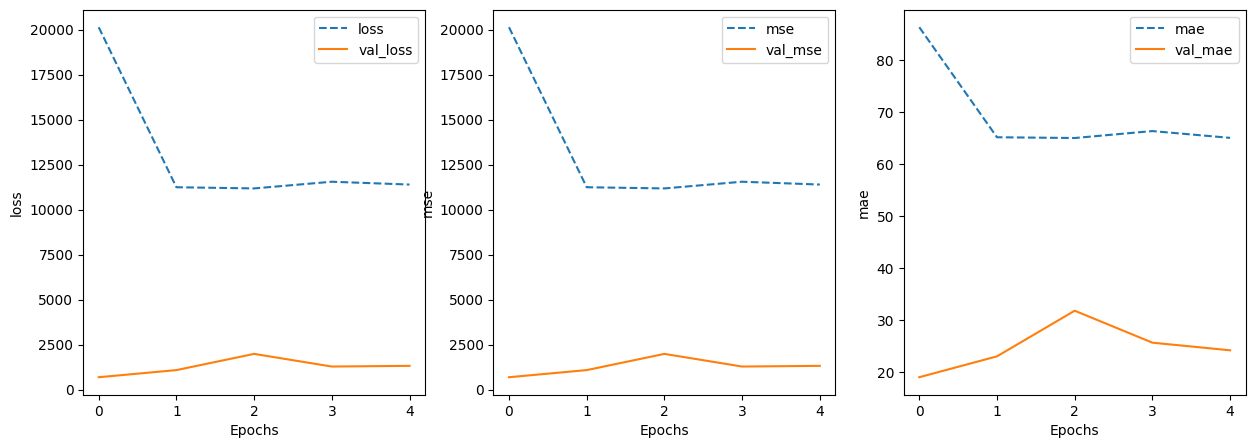

In [ ]:
NUM_TRAIN = 200 # 10000 more realistic
NUM_EVAL = 10 # 1000 more realistic
NUM_EPOCHS = 5

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_filters = 32):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
  eval_dataset = create_dataset(NUM_EVAL).batch(64)

  # a simple convnet. you can make it more complex, of course
  # the patch is flattened, so we start by reshaping to an image
  model = tf.keras.Sequential([
              tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
                                      input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
              tf.keras.layers.Conv2D(num_filters, (7,7), activation='relu'),
              tf.keras.layers.MaxPooling2D((3, 3) , strides= 2 ),
              tf.keras.layers.Conv2D(num_filters, (1,1), activation='relu'),
              tf.keras.layers.Conv2D(num_filters, (5,5), activation='relu'),
              tf.keras.layers.MaxPooling2D((3, 3)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(num_filters*2,
                                    kernel_regularizer=regularizer,
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dropout(0.65),
              tf.keras.layers.Dense(1, activation='linear')
  ])

  # model = tf.keras.Sequential([
  #             tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
  #                                     input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
  #             tf.keras.layers.Conv2D(num_filters, (3,3), activation='relu'),
  #             tf.keras.layers.MaxPooling2D((2, 2)),
  #             tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
  #             tf.keras.layers.MaxPooling2D((2, 2)),
  #             tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
  #             tf.keras.layers.Flatten(),
  #             tf.keras.layers.Dense(num_filters*2,
  #                                   kernel_regularizer=regularizer,
  #                                   activation=tf.keras.activations.relu),
  #             tf.keras.layers.Dense(1, activation='linear')
  # ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=['mse', 'mae'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
  training_plot(['loss', 'mse', 'mae'], history)
  return model

model = train_and_evaluate()

Total # berries 154 , red berries simulated 81 , black berries simulated 73
8/8 [==============================] - 1s 69ms/step
Total # berries 156 , red berries simulated 67 , black berries simulated 89
8/8 [==============================] - 1s 121ms/step
Total # berries 168 , red berries simulated 85 , black berries simulated 83
8/8 [==============================] - 1s 109ms/step
Total # berries 200 , red berries simulated 95 , black berries simulated 105
8/8 [==============================] - 1s 130ms/step
Total # berries 159 , red berries simulated 81 , black berries simulated 78
8/8 [==============================] - 1s 129ms/step
Total # berries 191 , red berries simulated 95 , black berries simulated 96
8/8 [==============================] - 1s 132ms/step
Total # berries 154 , red berries simulated 70 , black berries simulated 84
8/8 [==============================] - 1s 121ms/step
Total # berries 225 , red berries simulated 111 , black berries simulated 114
8/8 [==============

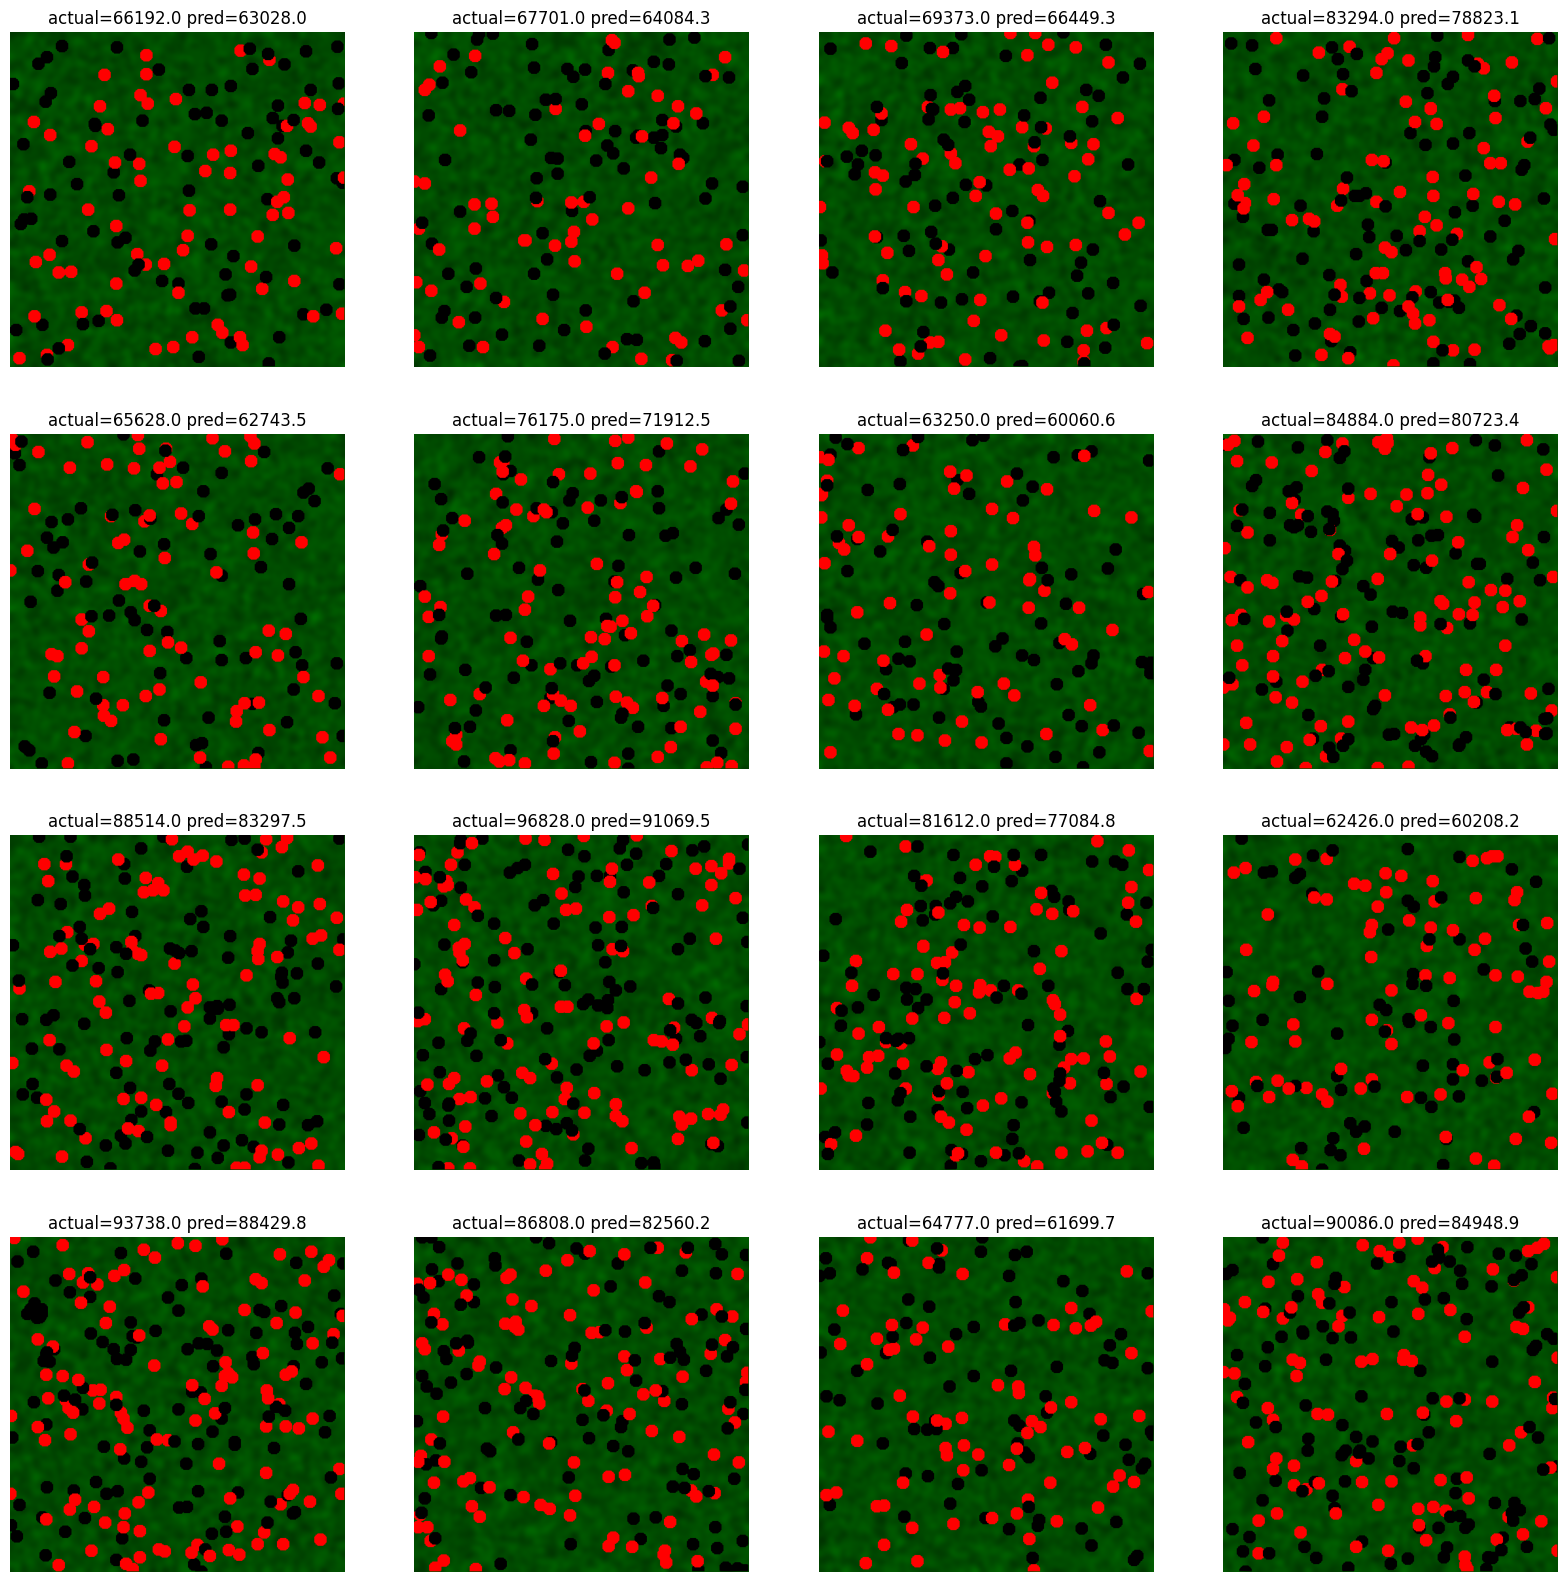

In [7]:
## prediction.
def count_berries(model, img):
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  img = tf.expand_dims(img, axis=0)
  patches = tf.image.extract_patches(img,
                sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                rates=[1, 1, 1, 1],
                padding='SAME',
                name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  densities = model.predict(patches)
  return tf.reduce_sum(densities)

# use an example image
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  backgr, berries, img, label = generate_image(True)
  ax[idx//4, idx%4].imshow(img)
  ax[idx//4, idx%4].set_title("actual={:.1f} pred={:.1f}".format(
    tf.reduce_sum(label).numpy(),
    count_berries(model, img).numpy()
  ))
  ax[idx//4, idx%4].axis('off')

Model was updated to match the CNN model from the [Article https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5426829/].
Kernel of 7 x 7 was used
Besides trying to usng the convolution & max pooling layers. Also used the drop layers with 65 % rate.  

Al of get the red and black cheries , we had to use the dia-together DAIHRAM 5)7
